# Assignment 2 : Language Modeling & Evaluation 

**Student names**: Vegard Aa Albretsen <br>
**Group number**: Group 62 <br>
**Date**: _We will see_

## Important notes
Please read and follow these rules. Submissions that do not fulfill them may be returned.
1. You may work in groups of maximum 2 students.
2. Submit in **.ipynb** format only.
3. The assignment must be typed. Handwritten answers are not accepted.

**Due date**: 28.09.2025 23:59

### What you will do
- Build a **unigram document language model** with a **document-term matrix**.
- Rank documents for queries using **Jelinek-Mercer smoothing**.
- Evaluate the run using **Cranfield queries and qrels** (P@k, MAP, MRR).
- (Optional) Try **Dirichlet** and compare briefly.


---
## Dataset

Make sure the Cranfield files are placed next to the notebook:
- `cran.all.1400` — document collection (1400 docs)
- `cran.qry` — queries
- `cranqrel` — relevance judgments (qrels)

> Only the **document parsing** for cran.all.1400 code is provided below. You will implement the rest in the TODO cells.


### Load and parse documents (provided)

Run the cell to parse the Cranfield documents. Update the path so it points to your `cran.all.1400` file.


In [4]:
# TODO: Read 'cran.all.1400' and parse the documents into a suitable data structure

CRAN_PATH = r"cran.all.1400"  # <-- change this!

def parse_cranfield(path):
    docs = {} # docs : Dict[int, Dict[str, Union[int, str]]] -> {id: {id, title, abstract}}
    current_id = None
    current_field = None
    buffers = {"T": [], "A": [], "B": [], "W": []}
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.rstrip("\n")
            if line.startswith(".I "):
                if current_id is not None:
                    docs[current_id] = {
                        "id": current_id,
                        "title": " ".join(buffers["T"]).strip(),
                        "abstract": " ".join(buffers["W"]).strip()
                    }
                current_id = int(line.split()[1])
                buffers = {k: [] for k in buffers}
                current_field = None
            elif line.startswith("."):
                tag = line[1:].strip()
                current_field = tag if tag in buffers else None
            else:
                if current_field is not None:
                    buffers[current_field].append(line)
    if current_id is not None:
        docs[current_id] = {
            "id": current_id,
            "title": " ".join(buffers["T"]).strip(),
            "abstract": " ".join(buffers["W"]).strip()
        }
    print(f"Parsed {len(docs)} documents.")
    return docs

docs = parse_cranfield(CRAN_PATH)
print(list(docs.items())[:1])  # peek at the first parsed doc


Parsed 1400 documents.
[(1, {'id': 1, 'title': 'experimental investigation of the aerodynamics of a wing in a slipstream .', 'abstract': 'experimental investigation of the aerodynamics of a wing in a slipstream .   an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem .   the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary-layer-control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory .   an empirical evaluation of the destalling effects was made fo

## 2.1 Language Modeling

You will create a **unigram language model** per document, using a **document-term matrix**, and score queries with **Jelinek-Mercer smoothing**.


### 2.1.1 Preprocessing

Implement a simple tokenizer/normalizer (e.g., lowercasing, punctuation removal and stopword removal) and apply it to each document

- Return a list of tokens for each document.


In [5]:
# TODO: Implement preprocessing and apply to all documents

STOPWORDS = set("""a about above after again against all am an and any are aren't as at be because been
before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down
during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers
herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most
mustn't my myself no nor not of off on once only or other ought our ours ourselves out over own same shan't she
she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's
these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're
we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't
you you'd you'll you're you've your yours yourself yourselves""".split())

import re

def preprocess(text): 
    text = text.lower()
    tokens = re.findall(r'\b[a-zA-Z]+\b', text)
    tokens = [token for token in tokens if token not in STOPWORDS]
    return tokens

for doc_id, doc_data in docs.items():
    combined_text = doc_data['title'] + " " + doc_data['abstract']
    doc_data['tokens'] = preprocess(combined_text)


print(f"Example document tokens: {list(docs.items())[0][1]['tokens'][:10]}")
print(f"Document 1 has {len(docs[1]['tokens'])} tokens")


Example document tokens: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream', 'experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']
Document 1 has 84 tokens


### 2.1.2 Build the matrix

Construct:
- A vocabulary `term -> column_index`
- A (sparse) **document–term count matrix**
- Document lengths `|d|` and collection (all documents) totals

> Tip: You may use dictionaries or `scipy.sparse` for efficiency.


In [6]:
# TODO: Build vocabulary, doc-term counts (sparse), document lengths, and collection totals
from collections import defaultdict
vocabulary = set()
doc_term_counts = {'term':str,'count':int}
for doc_id, doc_data in docs.items():
    for token in doc_data['tokens']:
        vocabulary.add(token)

vocab_to_idx = {term: idx for idx, term in enumerate(vocabulary)}

doc_term_counts = {}
doc_lengths = {}
collection_totals = defaultdict(int)

for doc_id, doc_data in docs.items():
    term_counts = defaultdict(int)
    for token in doc_data['tokens']:
        term_counts[token] += 1
        collection_totals[token] +=1
    
    doc_term_counts[doc_id] = dict(term_counts)
    doc_lengths[doc_id] = len(doc_data['tokens'])

print(f"Vocabulary size: {len(vocabulary)}")
print(f"Total documents: {len(doc_term_counts)}")
print(f"Document 1 length: {doc_lengths[1]}")
print(f"Total collection tokens: {sum(collection_totals.values())}")

Vocabulary size: 6928
Total documents: 1400
Document 1 length: 84
Total collection tokens: 140876


### 2.1.3 Rank with **Jelinek-Mercer smoothing**

Implement query likelihood scoring with Jelinek-Mercer smoothing:

$\hat{P}(t \mid M_d) = \lambda \hat{P}_{\text{mle}}(t \mid M_d) + (1 - \lambda)\hat{P}_{\text{mle}}(t \mid M_c), \ \lambda = 0.5$



In [56]:
def jelinek_smoothing(query: str):
    # 1. Setup
    smooth_par = 0.5
    total_collection_tokens = sum(collection_totals.values())

    # 2. Query processing
    query_tokens = preprocess(query)
    
    if not query_tokens:
        print("WARNING: Query is empty after preprocessing!")
        return list(docs.keys())
    
    # 3. Document scoring loop
    document_scores = {}
    
    for doc_id, doc_data in docs.items():
        doc_length = len(doc_data['tokens'])
        if doc_length == 0:
            document_scores[doc_id] = float('-inf')  # Give empty docs worst possible score
            continue
            
        document_scores[doc_id] = 0.0  # Only initialize non-empty docs
        
        # 4. Term probability calculation
        for term in query_tokens:
            term_freq_doc = doc_term_counts[doc_id].get(term, 0)
            term_freq_collection = collection_totals.get(term, 0)

            # FIXED: Don't skip terms not in collection, give them small probability
            if term_freq_collection == 0:
                # Use small smoothing for unseen terms
                collection_prob = 1e-10 / total_collection_tokens
            else:
                collection_prob = term_freq_collection / total_collection_tokens

            doc_prob = term_freq_doc / doc_length

            # 5. Apply smoothing formula
            p_smoothed = (smooth_par * doc_prob) + ((1 - smooth_par) * collection_prob)
            
            # Safety check
            if p_smoothed <= 0:
                print(f"WARNING: p_smoothed = {p_smoothed}")
                p_smoothed = 1e-10
                
            log_smoothed = np.log(p_smoothed)
            document_scores[doc_id] += log_smoothed

    # 6. Ranking
    ranked_docs = sorted(document_scores.items(), key=lambda x: x[1], reverse=True)
    ranked_doc_ids = [doc_id for doc_id, score in ranked_docs]

    return ranked_doc_ids

In [30]:
# Do not change this code
queries_assignment2 = [
  "gas pressure",
  "structural aeroelastic flight high speed aircraft",
  "heat conduction composite slabs",
  "boundary layer control",
  "compressible flow nozzle",
  "combustion chamber injection",
  "laminar turbulent transition",
  "fatigue crack growth",
  "wing tip vortices",
  "propulsion efficiency"
]

In [33]:
# Run Jelinek-Mercer smoothing on queries in batch (print top-10 results for each), using the function you created
def run_batch_smoothing(queries):
    results = {}
    for i, q in enumerate(queries, 1):
        res = jelinek_smoothing(q)
        results[f"Q{i}"] = res
    return results

jelinek_results = run_batch_smoothing(queries_assignment2)

for qid, res in jelinek_results.items():
    print(qid, "=>", res[:10])


Q1 => [169, 183, 1003, 1312, 1143, 1315, 1274, 975, 1319, 1139]
Q2 => [12, 141, 746, 51, 875, 1169, 1170, 884, 14, 1263]
Q3 => [399, 5, 144, 485, 181, 542, 582, 1073, 119, 91]
Q4 => [265, 1205, 1288, 416, 3, 974, 4, 1349, 342, 933]
Q5 => [118, 389, 775, 965, 217, 326, 941, 984, 1187, 539]
Q6 => [1143, 1241, 1254, 1180, 595, 635, 1195, 691, 696, 1269]
Q7 => [418, 558, 337, 96, 207, 526, 959, 1264, 1287, 9]
Q8 => [1196, 768, 884, 726, 883, 558, 330, 865, 909, 835]
Q9 => [675, 433, 246, 434, 288, 289, 793, 222, 1342, 902]
Q10 => [968, 1328, 1380, 1092, 592, 578, 182, 1151, 1270, 1211]


#### Dirichlet

If you have time, also implement Dirichlet smoothing and briefly compare the top-10 lists for the first query in the queries_assignment2 list


In [ ]:
# TODO (Optional): Implement Dirichlet scoring and compare with Jelinek-Mercer
# Your code here


## 2.2 Evaluation (Cranfield queries + qrels)

Evaluate your retrieval system using **Cranfield**:
- Parse **queries** from `cran.qry`
- Parse **relevance judgments** from `cranqrel`
- Compute **P@k (k=5,10)**, **MAP (Mean Average Precision)**, and **MRR (Mean Reciprocal Rank)** over all queries


### 2.2.1 Parse `cran.qry` and `cranqrel`

- Create `queries[qid] = "text"` by parsing `cran.qry`
- Create `qrels[qid] = set(relevant_doc_ids)` by parsing `cranqrel`


In [63]:
# TODO: Parse cran.qry and cranqrel into convenient data structures

def parse_queries(path):
    """Parse cran.qry file into queries dictionary"""
    queries = {}
    current_id = None
    current_text = []
    
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.rstrip("\n")
            if line.startswith(".I "):
                # Save previous query
                if current_id is not None:
                    queries[current_id] = " ".join(current_text).strip()
                # Start new query
                current_id = int(line.split()[1])
                current_text = []
            elif line.startswith(".W"):
                # Query text starts after .W
                continue
            elif not line.startswith("."):
                # Collect query text lines
                if current_id is not None:
                    current_text.append(line)
        
        # Save the last query
        if current_id is not None:
            queries[current_id] = " ".join(current_text).strip()
    
    print(f"Parsed {len(queries)} queries.")
    return queries

def parse_qrels(path):
    """Parse cranqrel file into relevance judgments dictionary"""
    qrels = {}
    
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) >= 3:
                    query_id = int(parts[0])
                    doc_id = int(parts[1])
                    relevance = int(parts[2])
                    
                    # Only consider documents with relevance > 0 as relevant
                    if relevance > 0:
                        if query_id not in qrels:
                            qrels[query_id] = set()
                        qrels[query_id].add(doc_id)
    
    print(f"Parsed relevance judgments for {len(qrels)} queries.")
    return qrels

# Parse both files
queries = parse_queries("cran.qry")
qrels = parse_qrels("cranqrel")

# Display some examples
print("\nExample queries:")
for qid in sorted(list(queries.keys())[:3]):
    print(f"Q{qid}: {queries[qid][:80]}...")

print("\nExample qrels:")
for qid in sorted(list(qrels.keys())[:3]):
    print(f"Q{qid}: {len(qrels[qid])} relevant docs -> {sorted(list(qrels[qid]))[:5]}...")

Parsed 225 queries.
Parsed relevance judgments for 225 queries.

Example queries:
Q1: what similarity laws must be obeyed when constructing aeroelastic models of heat...
Q2: what are the structural and aeroelastic problems associated with flight of high ...
Q4: what problems of heat conduction in composite slabs have been solved so far ....

Example qrels:
Q1: 28 relevant docs -> [12, 13, 14, 15, 29]...
Q2: 24 relevant docs -> [12, 14, 15, 51, 52]...
Q3: 8 relevant docs -> [5, 6, 90, 91, 119]...


### 2.2.2 Implement metrics: P@k, MAP, MRR

Write functions to compute:
- Precision@k (for **k=5** and **k=10**)
- Mean Average Precision (MAP)
- Mean Reciprocal Rank (MRR)


In [64]:
# TODO: Implement P@k (k=5,10), MAP, and MRR
import numpy as np

def precision_at_k(retrieved, relevant, k):
    """Calculate Precision@k"""
    if k <= 0:
        return 0.0
    
    top_k = retrieved[:k]
    relevant_retrieved = sum(1 for doc_id in top_k if doc_id in relevant)
    return relevant_retrieved / k

def average_precision(retrieved, relevant):
    """Calculate Average Precision for a single query"""
    if not relevant:
        return 0.0
    
    relevant_retrieved = 0
    precision_sum = 0.0
    
    for rank, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_retrieved += 1
            precision_at_rank = relevant_retrieved / rank
            precision_sum += precision_at_rank
    
    return precision_sum / len(relevant)

def reciprocal_rank(retrieved, relevant):
    """Calculate Reciprocal Rank for a single query"""
    for rank, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            return 1.0 / rank
    return 0.0

def evaluate_retrieval(queries, qrels, retrieval_function):
    """Evaluate retrieval system with P@k, MAP, and MRR"""
    
    results = {
        'per_query': {},
        'p_at_5': [],
        'p_at_10': [],
        'average_precisions': [],
        'reciprocal_ranks': []
    }
    
    for query_id in sorted(queries.keys()):
        if query_id not in qrels or not qrels[query_id]:
            continue
            
        query_text = queries[query_id]
        relevant_docs = qrels[query_id]
        retrieved_docs = retrieval_function(query_text)
        
        # Calculate metrics
        p_at_5 = precision_at_k(retrieved_docs, relevant_docs, 5)
        p_at_10 = precision_at_k(retrieved_docs, relevant_docs, 10)
        avg_precision = average_precision(retrieved_docs, relevant_docs)
        rr = reciprocal_rank(retrieved_docs, relevant_docs)
        
        # Store results
        results['per_query'][query_id] = {
            'p_at_5': p_at_5,
            'p_at_10': p_at_10,
            'average_precision': avg_precision,
            'reciprocal_rank': rr,
            'num_relevant': len(relevant_docs)
        }
        
        results['p_at_5'].append(p_at_5)
        results['p_at_10'].append(p_at_10)
        results['average_precisions'].append(avg_precision)
        results['reciprocal_ranks'].append(rr)
    
    # Calculate aggregate metrics
    num_queries = len(results['p_at_5'])
    if num_queries > 0:
        results['mean_p_at_5'] = np.mean(results['p_at_5'])
        results['mean_p_at_10'] = np.mean(results['p_at_10'])
        results['map'] = np.mean(results['average_precisions'])
        results['mrr'] = np.mean(results['reciprocal_ranks'])
        results['num_evaluated_queries'] = num_queries
    else:
        results['mean_p_at_5'] = 0.0
        results['mean_p_at_10'] = 0.0
        results['map'] = 0.0
        results['mrr'] = 0.0
        results['num_evaluated_queries'] = 0
    
    return results

### 2.2.3 Evaluate your run

- For **all queries**, generate rankings with your **Jelinek-Mercer** model
- Report aggregate metrics: P@5, P@10, MAP, MRR


In [65]:
# TODO: Run retrieval for all queries and compute P@5, P@10, MAP, and MRR

# Run evaluation
evaluation_results = evaluate_retrieval(queries, qrels, jelinek_smoothing)

print(f"Evaluated {evaluation_results['num_evaluated_queries']} queries")
print(f"P@5: {evaluation_results['mean_p_at_5']:.3f}")
print(f"P@10: {evaluation_results['mean_p_at_10']:.3f}")
print(f"MAP: {evaluation_results['map']:.3f}")
print(f"MRR: {evaluation_results['mrr']:.3f}")

Evaluated 152 queries
P@5: 0.012
P@10: 0.014
MAP: 0.014
MRR: 0.029



### 2.2.4 Interpolated precision–recall curves (11‑point)

- For **all queries**, if you don’t have query IDs, assign sequential IDs: `Q1, Q2, ..., Qm` in the order they appear.
- Using your **rankings from task 2.2.3** and the **relevance judgments (`cranqrel`)**, compute **precision** and **recall** at each rank for each query.
- For the 11 standard recall levels `R = {0.0, 0.1, ..., 1.0}`, compute the **interpolated precision** at level `r` as the **maximum precision** observed at any point with recall ≥ `r`.
- **Report/plot** the **11‑point interpolated precision–recall curve** across queries (and optionally a few per‑query curves).

11-point interpolated precision-recall:
  0.0: 0.036
  0.1: 0.033
  0.2: 0.023
  0.3: 0.015
  0.4: 0.014
  0.5: 0.013
  0.6: 0.011
  0.7: 0.010
  0.8: 0.009
  0.9: 0.008
  1.0: 0.008


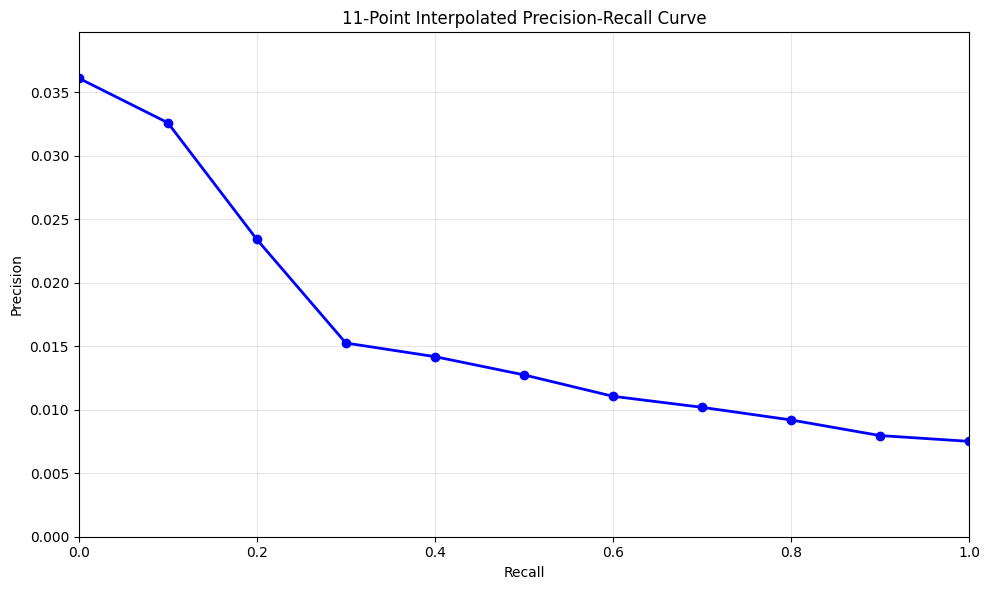

In [67]:
# TODO: Compute the 11-point interpolated precision–recall for each query

import matplotlib.pyplot as plt
import numpy as np

def compute_precision_recall_curve(retrieved, relevant):
    """Compute precision and recall at each rank for a single query"""
    if not relevant:
        return [], []
    
    precisions = []
    recalls = []
    relevant_retrieved = 0
    
    for rank, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_retrieved += 1
        
        precision = relevant_retrieved / rank
        recall = relevant_retrieved / len(relevant)
        
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

def interpolated_precision_at_recall_levels(precisions, recalls, recall_levels):
    """Compute 11-point interpolated precision-recall"""
    interpolated_precisions = []
    
    for target_recall in recall_levels:
        max_precision = 0.0
        for p, r in zip(precisions, recalls):
            if r >= target_recall:
                max_precision = max(max_precision, p)
        interpolated_precisions.append(max_precision)
    
    return interpolated_precisions

# Define 11 standard recall levels
recall_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Compute interpolated precision-recall for all queries
all_interpolated_precisions = []

for query_id in sorted(queries.keys()):
    if query_id not in qrels or not qrels[query_id]:
        continue
    
    retrieved = jelinek_smoothing(queries[query_id])
    relevant = qrels[query_id]
    
    precisions, recalls = compute_precision_recall_curve(retrieved, relevant)
    interpolated_precisions = interpolated_precision_at_recall_levels(precisions, recalls, recall_levels)
    all_interpolated_precisions.append(interpolated_precisions)

# Compute average interpolated precision across all queries
avg_interpolated_precisions = np.mean(all_interpolated_precisions, axis=0)

print(f"11-point interpolated precision-recall:")
for recall, precision in zip(recall_levels, avg_interpolated_precisions):
    print(f"  {recall:.1f}: {precision:.3f}")

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(recall_levels, avg_interpolated_precisions, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Interpolated Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, max(avg_interpolated_precisions) * 1.1 if max(avg_interpolated_precisions) > 0 else 0.1)
plt.tight_layout()
plt.show()